In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Load and preprocess the data
data = pd.read_excel('Acceleration1.xlsx', sheet_name='11')
X = data[['Top Offset error (%)', 
          'Bottom Offset error (%)']].values
y = data['Angle of Reverse Parking'].values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train the SVM model
svm_model = SVR(kernel='linear')
svm_model.fit(X, y)

# Load the data for the additional 4 drivers
driver_data = pd.read_excel('Acceleration1.xlsx', sheet_name='12')
X_driver = driver_data[['Top Offset error (%)', 
          'Bottom Offset error (%)']].values

# Standardize the data for the additional 4 drivers
X_driver = scaler.transform(X_driver)

# Predict the time to park for the additional 4 drivers
y_pred = svm_model.predict(X_driver)

# Calculate the mean and standard deviation of the time to finish the parallel parking for the 12 expert drivers
mean_time = np.mean(y)
std_time = np.std(y)
print(f"Mean horizontal angle after parking: {mean_time:.2f} degrees")

# Calculate the z-score for the time to finish the parallel parking for each of the additional 4 drivers
z_scores = (y_pred - mean_time) / std_time

# Convert the z-score to a percentile score between 0 and 100
percentile_scores = [100 * norm.cdf(z_score) for z_score in z_scores]

# Calculate the skill level for each driver
observed_time = driver_data['Observed Angle of Reverse Parking'].values
predicted_time = y_pred
scores = 5 - (abs(observed_time - predicted_time) / observed_time) * 5
scores = np.clip(scores, 0, 5)
driver_skill = []
for i in range(len(percentile_scores)):
    if observed_time[i] > mean_time:
        driver_skill.append('Below Average')
    else:
        driver_skill.append('Above Average')
    print(f"Driver {i+1} skill level: {driver_skill[i]}")

for i in range(len(scores)):
    print(f"The score for driver {i+1} is {scores[i]*20:.2f}, Predicted angle: {y_pred[i]:.2f} degrees, Observed angle: {observed_time[i]:.2f} degrees")


Mean horizontal angle after parking: 5.43 degrees
Driver 1 skill level: Below Average
Driver 2 skill level: Above Average
Driver 3 skill level: Above Average
Driver 4 skill level: Above Average
The score for driver 1 is 52.20, Predicted angle: 8.11 degrees, Observed angle: 5.49 degrees
The score for driver 2 is 70.26, Predicted angle: 3.31 degrees, Observed angle: 2.55 degrees
The score for driver 3 is 34.04, Predicted angle: 4.98 degrees, Observed angle: 3.00 degrees
The score for driver 4 is 19.39, Predicted angle: 4.79 degrees, Observed angle: 2.65 degrees


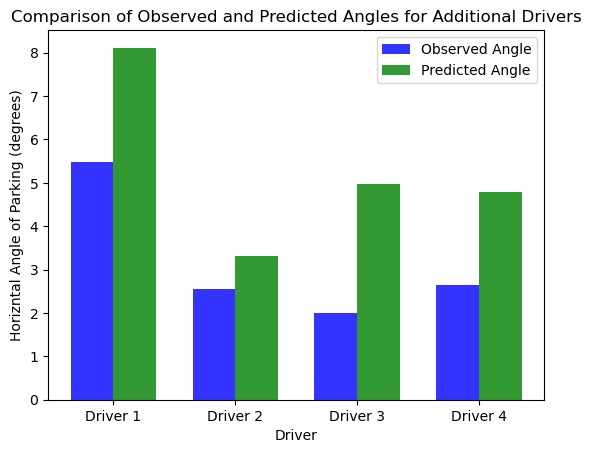

In [2]:
import matplotlib.pyplot as plt

# Create a bar chart to compare observed and predicted times for the additional drivers
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8
index = np.arange(len(observed_time))
rects1 = ax.bar(index, observed_time, bar_width, alpha=opacity, color='b', label='Observed Angle')
rects2 = ax.bar(index + bar_width, predicted_time, bar_width, alpha=opacity, color='g', label='Predicted Angle')

# Set the labels, title and ticks for the bar chart
ax.set_xlabel('Driver')
ax.set_ylabel('Horizntal Angle of Parking (degrees)')
ax.set_title('Comparison of Observed and Predicted Angles for Additional Drivers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Driver 1', 'Driver 2', 'Driver 3', 'Driver 4'))
ax.legend()

# Display the bar chart
plt.show()


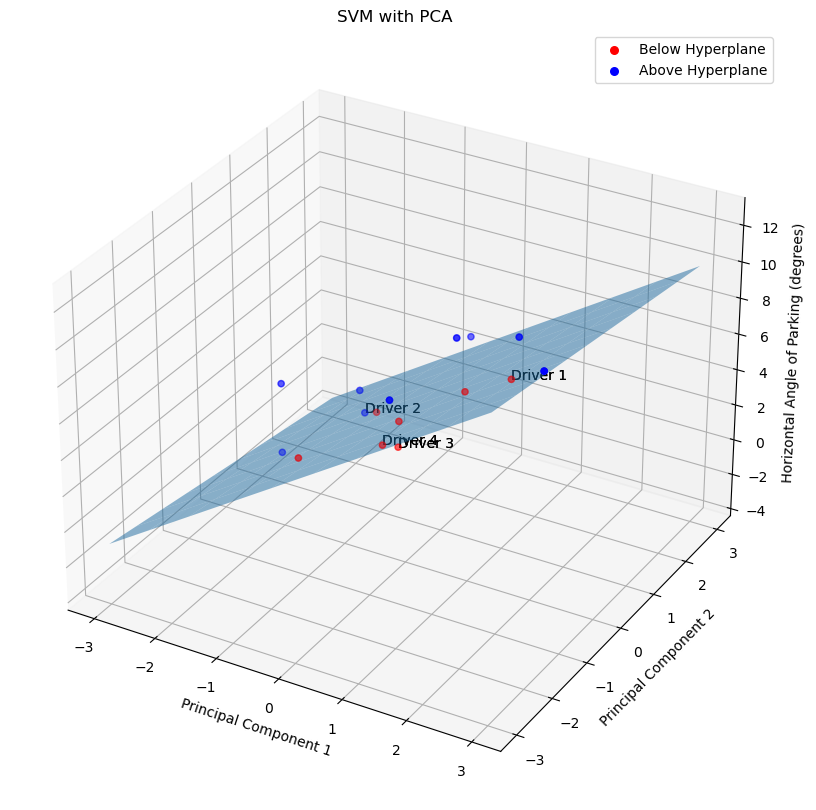

In [5]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and preprocess the data
data = pd.read_excel('Acceleration1.xlsx', sheet_name='11')
X = data[['Top Offset error (%)', 
          'Bottom Offset error (%)']].values
y = data['Angle of Reverse Parking'].values

# Load the data for the additional 4 drivers
driver_data = pd.read_excel('Acceleration1.xlsx', sheet_name='12')
X_driver = driver_data[['Top Offset error (%)', 
          'Bottom Offset error (%)']].values
y_driver = driver_data['Observed Angle of Reverse Parking'].values

# Merge the data for the 12 drivers and the additional 4 drivers
X_all = np.concatenate((X, X_driver), axis=0)
y_all = np.concatenate((y, y_driver), axis=0)

# Standardize the data
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_all_pca = pca.fit_transform(X_all)
X_pca = pca.fit_transform(X)

# Train the SVR model
svm_model = SVR(kernel='linear')
svm_model.fit(X_all_pca, y_all)

# Create a 3D scatter plot with colors based on the predicted values
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_all_pca[:, 0], X_all_pca[:, 1], y_all, c=np.where(svm_model.predict(X_all_pca) > y_all, 'r', 'b'), cmap='coolwarm')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Horizontal Angle of Parking (degrees)')
ax.set_title('SVM with PCA')

# Plot the hyperplane
xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
zz = np.array([svm_model.predict(np.array([x, y]).reshape(1, -1))[0] for x, y in zip(xx.ravel(), yy.ravel())])
zz = zz.reshape(xx.shape)
ax.plot_surface(xx, yy, zz, alpha=0.5)

for i, xy in enumerate(X_all_pca):
    if i < 12:
        continue  # Skip the first twelve drivers (the original training data)
    ax.text(xy[0], xy[1], y_all[i], f'Driver {i-11}', fontsize=10)

    # Label the additional drivers
    if i >= 12:
        ax.text(xy[0], xy[1], y_all[i], f'Driver {i-11}', fontsize=10)

# Set legend labels
scatter1 = ax.scatter([], [], c='r', s=30, label='Below Hyperplane')
scatter2 = ax.scatter([], [], c='b', s=30, label='Above Hyperplane')
ax.legend(handles=[scatter1, scatter2], labels=['Below Hyperplane', 'Above Hyperplane'])
        
# Color points above and below the hyperplane differently
z_pred = svm_model.predict(X_all_pca)
colors = np.where(z_pred > y_all, 'r', 'b')
ax.scatter(X_all_pca[:, 0], X_all_pca[:, 1], y_all, c=colors, cmap='coolwarm')
plt.show()

# Set legend labels
scatter1 = ax.scatter([], [], c='r', s=30, label='Below Hyperplane')
scatter2 = ax.scatter([], [], c='b', s=30, label='Above Hyperplane')



In [7]:
# Create a boolean mask for the points above the hyperplane
mask = svm_model.predict(X_pca) >= y
# Calculate the mean time for drivers above and below the hyperplane
mean_above = np.mean(y[mask])
mean_below = np.mean(y[~mask])

# Print the means
print(f"Mean angle for drivers above the hyperplane: {mean_above:.2f}")
print(f"Mean angle for drivers below the hyperplane: {mean_below:.2f}")

# Perform a t-test to determine if the difference is statistically significant
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(y[mask], y[~mask], equal_var=False)

# Print the t-statistic and p-value
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference in mean angles is statistically significant.")
else:
    print("The difference in mean angles is not statistically significant.")


Mean angle for drivers above the hyperplane: 8.22
Mean angle for drivers below the hyperplane: 4.03
t-statistic: 2.59
p-value: 0.0491
The difference in mean angles is statistically significant.
